 #HACKATHON ONE : SENTIMENT API CLASIFICACION DE SENTIMIENTOS

Una herramienta capaz de identificar si un comentario es positivo, negativo o neutro.

La solucion permite que las empresas comprendan rapidamente el tono de mensajes recibidos, sin necesidad de analizar uno por uno.

Los estudiantes deberan crear un modelo sencillo que realice esta clasificacion y poner el resultado a disposicion a traves de una API.

#SELECCION DE DATASET:


*   Amazon Reviews Spanish disponible en Hugging Face.
https://huggingface.co/datasets/SetFit/amazon_reviews_multi_es/viewer/default/train?views%5B%5D=train



##LIBRERIAS

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [13]:
# Carga de datos
splits = {'train': 'train.jsonl', 'validation': 'validation.jsonl', 'test': 'test.jsonl'}
df = pd.read_json("hf://datasets/SetFit/amazon_reviews_multi_es/" + splits["train"], lines=True)

# Mapeo de estrellas a sentimientos (Bueno/Malo/Regular)
# 1-2 estrellas: Malo | 3 estrellas: Regular | 4-5 estrellas: Bueno
def mapear_sentimiento(label):
    if label < 2: return "Malo"      # Etiquetas 0 y 1
    if label == 2: return "Regular" # Etiqueta 2
    return "Bueno"                  # Etiquetas 3 y 4

df['sentimiento'] = df['label'].apply(mapear_sentimiento)
print(f"Dataset cargado: {df.shape[0]} registros.")
df[['text', 'sentimiento']].head()


Dataset cargado: 200000 registros.


,text,sentimiento
0,Nada bueno se me fue ka pantalla en menos de 8...,Malo
1,"Horrible, nos tuvimos que comprar otro porque ...",Malo
2,Te obligan a comprar dos unidades y te llega s...,Malo
3,"No entro en descalificar al vendedor, solo pue...",Malo
4,Llega tarde y co la talla equivocada,Malo


##Exploracion y limpieza de los datos (EDA)

/tmp/ipython-input-3792881925.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentimiento', data=df, palette='viridis')


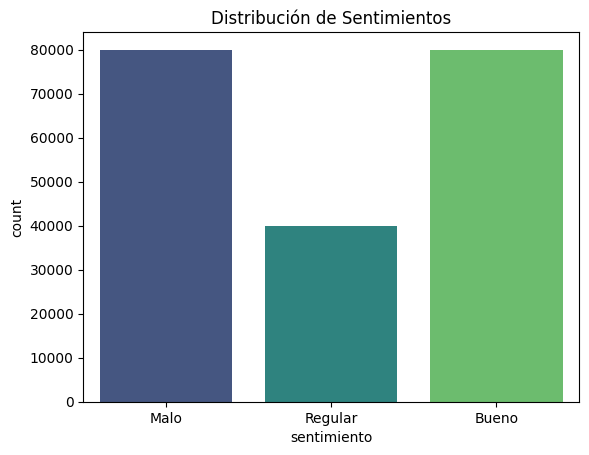

In [14]:
# Distribución de clases
sns.countplot(x='sentimiento', data=df, palette='viridis')
plt.title('Distribución de Sentimientos')
plt.show()

# Limpieza básica de texto (minúsculas y remoción de caracteres especiales)
import re

def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s]', '', texto) # Eliminar puntuación
    texto = re.sub(r'\d+', '', texto) # Eliminar números
    return texto

df['comentario_limpio'] = df['text'].apply(limpiar_texto)



In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   id                 200000 non-null  object
 1   text               200000 non-null  object
 2   label              200000 non-null  int64 
 3   label_text         200000 non-null  int64 
 4   sentimiento        200000 non-null  object
 5   comentario_limpio  200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 9.2+ MB


##Transformacion de los textos con TF-IDF

In [16]:
#Datos de entrada (X, las características) y la variable objetivo (y, las etiquetas)
X = df['comentario_limpio']
y = df['sentimiento']

# Dividir en entrenamiento y prueba (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

# Vectorización con TF-IDF
#Inicializar el vectorizador
vectorizer = TfidfVectorizer(

    lowercase=True,
    #stop_words=['de', 'el', 'la'], # Lista personalizada
    ngram_range=(1, 2),            # Unigramas y Bigramas
    min_df=10,                      # Ignorar si aparece en menos de 10 docs
    max_features=25000            # Solo las 25 000 mejores palabras
)
#Ajustar y transformar el texto a una matriz numérica
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Vocabulario creado: {len(vectorizer.get_feature_names_out())} términos")



Vocabulario creado: 25000 términos


##Entrenamiento del modelo supervisado (ej.: Logistic Regression, Naive Bayes)

In [17]:
# Entrenamiento
#modelo = LogisticRegression(max_iter=1000, multi_class='multinomial')
modelo = LogisticRegression(max_iter=3000)
modelo.fit(X_train_tfidf, y_train)


# Predicción
y_pred = modelo.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)

print(f"Precisión del modelo: {accuracy:.2f}")

Precisión del modelo: 0.74


##Métricas de desempeño (Accuracy, Precision, Recall, F1-score);

--- Reporte de Clasificación ---
              precision    recall  f1-score   support

       Bueno       0.80      0.85      0.83     16000
        Malo       0.76      0.85      0.80     16000
     Regular       0.46      0.29      0.36      8000

    accuracy                           0.74     40000
   macro avg       0.67      0.66      0.66     40000
weighted avg       0.72      0.74      0.72     40000



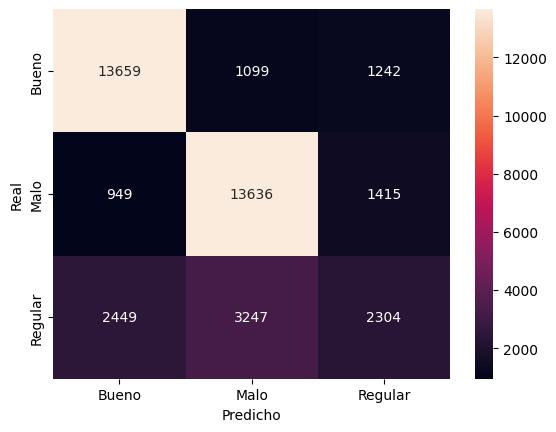

In [18]:
print("--- Reporte de Clasificación ---")
print(classification_report(y_test, y_pred))

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=modelo.classes_, yticklabels=modelo.classes_)
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()


##Serialización del modelo (joblib/pickle).

In [19]:
# Guardar el modelo y el vectorizador
joblib.dump(modelo, 'modelo_sentimientos_2025.pkl')
joblib.dump(vectorizer, 'vectorizador_tfidf.pkl')

print("Modelo y vectorizador guardados exitosamente como archivos .pkl")


Modelo y vectorizador guardados exitosamente como archivos .pkl


#PRUEBA DE PREDICCION

In [20]:
def predecir_nuevo(comentario):
    # Cargar si fuera necesario: mod = joblib.load('modelo_sentimientos_2025.pkl')
    limpio = limpiar_texto(comentario)
    vectorizado = vectorizer.transform([limpio])
    resultado = modelo.predict(vectorizado)
    return resultado[0]

# Prueba rápida
nuevo_comentario = "La comida estaba pasable pero el mesero fue lento"
print(f"Comentario: {nuevo_comentario} -> Sentimiento: {predecir_nuevo(nuevo_comentario)}")


Comentario: La comida estaba pasable pero el mesero fue lento -> Sentimiento: Regular


In [21]:
nuevo_comentario = "El servicio al cliente no me gusto nada"
print(f"Comentario: {nuevo_comentario} -> Sentimiento: {predecir_nuevo(nuevo_comentario)}")

Comentario: El servicio al cliente no me gusto nada -> Sentimiento: Malo


In [22]:
nuevo_comentario = "Me encanto la pantalla y todo lo de las especificaciones coincidian"
print(f"Comentario: {nuevo_comentario} -> Sentimiento: {predecir_nuevo(nuevo_comentario)}")

Comentario: Me encanto la pantalla y todo lo de las especificaciones coincidian -> Sentimiento: Bueno
